In [25]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import xarray as xr
import numpy as np

# Load dataset with xarray
filename_aviso='f:/data/eddy/aviso/eddy_trajectory_19930101_20170106.nc'   #From AVISO  website
dataset = xr.open_dataset(filename_aviso)

dataset

<xarray.Dataset>
Dimensions:             (obs: 23086878)
Dimensions without coordinates: obs
Data variables:
    amplitude           (obs) float32 ...
    cyclonic_type       (obs) int8 ...
    latitude            (obs) float32 ...
    longitude           (obs) float32 ...
    observation_number  (obs) uint16 ...
    speed_average       (obs) float32 ...
    speed_radius        (obs) float32 ...
    time                (obs) datetime64[ns] ...
    track               (obs) uint32 ...
Attributes:
    Metadata_Conventions:      Unidata Dataset Discovery v1.0
    title:                     Mesoscale Eddies in Altimeter Observations of SLA
    institution:               CNES/CLS in collaboration with Oregon State Un...
    project:                   SSALTO/DUACS
    creator_url:               http://www.aviso.altimetry.fr
    creator_email:             aviso@altimetry.fr
    license:                   http://www.aviso.altimetry.fr/fileadmin/docume...
    summary:                   This dat

<class 'xarray.core.utils.Frozen'>


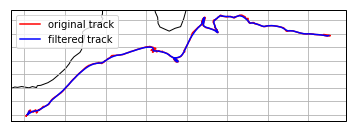

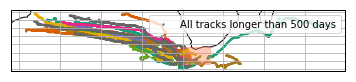

In [30]:
# Projection
proj=ccrs.PlateCarree()

#--------------------------------------------------------------------------------
# Follow a given eddy, plot its filtered track superimposed to its real track
#--------------------------------------------------------------------------------
# Select a specific eddy and save
subset = dataset.sel(obs=dataset.track==72553)
# Store selected data
subset.to_netcdf('eddy_trajectory_152014.nc')

# Position filtering with a rolling mean
windows_kwargs = dict(min_periods=7, obs=14, center=True)
new_lon = subset.longitude.rolling(** windows_kwargs).mean()
new_lat = subset.latitude.rolling(** windows_kwargs).mean()

# Create figure
fig = plt.figure()
# Create subplot
ax = fig.add_subplot(111, projection=proj)
# Plot the two tracks
ax.plot(subset.longitude, subset.latitude, color='r', label='original track', transform=proj)
ax.plot(new_lon, new_lat, color='b', label='filtered track', transform=proj)
# Active meridian/parallel
ax.gridlines()
# Active coastline
ax.coastlines()
# Legend
ax.legend()


#----------------------------------------------------------------------------------------------
# Select all eddies which go throught a given area and which have a lifespan more than 500 days
#----------------------------------------------------------------------------------------------

# Create figure
fig = plt.figure()
# Create subplot
ax = fig.add_subplot(111, projection=proj)
# Bounds of the area
lon_min, lon_max, lat_min, lat_max = 15, 25, -40, -34
# Draw area
ax.fill(
    [lon_min, lon_max, lon_max, lon_min, lon_min],
    [lat_min, lat_min, lat_max, lat_max, lat_min],
    color='coral',
    transform=proj,
    alpha=0.4,
    zorder=30)

# Select all observation in the area
subset = dataset.sel(
    obs=(dataset.longitude > lon_min) & (dataset.longitude < lon_max) & (dataset.latitude > lat_min) & (dataset.latitude < lat_max))
# Create a mask with all track which go throught the area
# Create the subset with the mask
subset = dataset.isel(obs=np.in1d(dataset.track, subset.track))
# Find all the track which are longer than 500 days
subset_lon_life =subset.sel(obs=subset.observation_number>500)
# Create the final subset
subset = subset.isel(obs=np.in1d(subset.track, subset_lon_life.track))

# Plot selected data
ax.scatter(
    subset.longitude,
    subset.latitude,
    c=subset.track,
    label='All tracks longer than 500 days',
    s=5,
    transform=proj,
    linewidth=0,
    cmap='Dark2')
# Active meridian/parallel
ax.gridlines()
# Active coastline
ax.coastlines()
# Legend
ax.legend()

# Store subset to further analyse
subset.to_netcdf('eddy_trajectory_area_days_more500.nc')

# Display figure
plt.show()


In [28]:

# Selection of all event with an amplitude over 40 cm
subset = dataset.sel(obs=dataset.amplitude>40.)
# save in netcdf file with same properties as before
subset.to_netcdf('eddy_trajectory_amplitude_more40.nc')

